In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls "/content/drive/MyDrive/Dataset1_saved"


Test  Train  Validation


In [ ]:
import os

base_dir = "/content/drive/MyDrive/Dataset1_saved"
splits = ['Train', 'Validation', 'Test']
classes = ['Real', 'Fake']

print("📂 Dataset Summary:\n")

valid_ext = ('.png', '.jpg', '.jpeg', '.jfif', '.webp', '.bmp')

for split in splits:
    print(f"--- {split} ---")
    split_path = os.path.join(base_dir, split)

    for cls in classes:
        class_path = os.path.join(split_path, cls)

        if os.path.exists(class_path):
            num_images = sum([
                len([f for f in files if f.lower().endswith(valid_ext)])
                for _, _, files in os.walk(class_path)
            ])
            print(f"{cls:>6}: {num_images} images")
        else:
            print(f"{cls:>6}: Folder not found ❌")
    print()

📂 Dataset Summary:

--- Train ---
  Real: 2508 images
  Fake: 2508 images

--- Validation ---
  Real: 708 images
  Fake: 708 images

--- Test ---
  Real: 252 images
  Fake: 252 images



In [ ]:
import os, shutil, random, math, cv2, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Flatten, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc


In [ ]:
import os
import cv2
import glob
import numpy as np
from tqdm import tqdm

DATA_ROOT = "/content/drive/MyDrive/Dataset1_saved"
                # your dataset
SEG_DIR = "/content/Dataset1_segmented"         # output segmented dataset

SPLITS = ["Train", "Validation", "Test"]
CLASSES = ["Real", "Fake"]

IMG_SIZE = (128, 128)

# -------------------------
# Face crop + segmentation
# -------------------------
def crop_face_and_segment(img_path):
    img = cv2.imread(img_path)
    if img is None:
        return None

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    face_cascade = cv2.CascadeClassifier(
        cv2.data.haarcascades + "haarcascade_frontalface_default.xml"
    )
    faces = face_cascade.detectMultiScale(gray, 1.1, 4, minSize=(30, 30))

    if len(faces) == 0:
        return cv2.resize(img, IMG_SIZE)

    x, y, w, h = faces[0]
    face = img[y:y+h, x:x+w]

    hsv = cv2.cvtColor(face, cv2.COLOR_BGR2HSV)
    lower = np.array([0, 30, 60])
    upper = np.array([20, 150, 255])
    mask = cv2.inRange(hsv, lower, upper)
    mask = cv2.GaussianBlur(mask, (5,5), 0)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, np.ones((5,5), np.uint8))

    if mask.sum() < 10:
        output = cv2.resize(face, IMG_SIZE)
    else:
        segmented = cv2.bitwise_and(face, face, mask=mask)
        output = cv2.resize(segmented, IMG_SIZE)

    return output


# -------------------------
# Create segmented folders
# -------------------------
for split in SPLITS:
    for cls in CLASSES:
        os.makedirs(os.path.join(SEG_DIR, split, cls), exist_ok=True)


print("\n========== STARTING SEGMENTATION ==========\n")

# -------------------------
# Segment split/classwise
# -------------------------
for split in SPLITS:
    print(f"\n🔄 Processing: {split}")

    for cls in CLASSES:
        print(f" → Class: {cls}")

        src_dir = os.path.join(DATA_ROOT, split, cls)
        dst_dir = os.path.join(SEG_DIR, split, cls)

        images = glob.glob(os.path.join(src_dir, "*"))

        for img_path in tqdm(images, desc=f"{split}-{cls}", unit="img"):
            try:
                out = crop_face_and_segment(img_path)
                if out is None:
                    continue

                out_rgb = cv2.cvtColor(out, cv2.COLOR_BGR2RGB)

                filename = os.path.basename(img_path)
                save_path = os.path.join(dst_dir, filename)

                # avoid filename clash
                if os.path.exists(save_path):
                    base, ext = os.path.splitext(filename)
                    save_path = os.path.join(dst_dir, base + "_dup" + ext)

                cv2.imwrite(save_path, cv2.cvtColor(out_rgb, cv2.COLOR_RGB2BGR))

            except Exception as e:
                print("Error:", img_path, e)


print("\n✅ Segmentation Completed!")
print("Segmented dataset saved at:", SEG_DIR)


# -------- Quick Count --------
print("\n📌 Segmented Image Counts:")
for split in SPLITS:
    for cls in CLASSES:
        count = len(glob.glob(os.path.join(SEG_DIR, split, cls, "*")))
        print(f"{split}/{cls}: {count} images")



========== STARTING SEGMENTATION ==========


🔄 Processing: Train
 → Class: Real


Train-Real: 100%|██████████| 2508/2508 [03:50<00:00, 10.90img/s]


 → Class: Fake


Train-Fake: 100%|██████████| 2508/2508 [03:53<00:00, 10.72img/s]



🔄 Processing: Validation
 → Class: Real


Validation-Real: 100%|██████████| 708/708 [01:04<00:00, 10.98img/s]


 → Class: Fake


Validation-Fake: 100%|██████████| 708/708 [01:02<00:00, 11.25img/s]



🔄 Processing: Test
 → Class: Real


Test-Real: 100%|██████████| 252/252 [00:21<00:00, 11.61img/s]


 → Class: Fake


Test-Fake: 100%|██████████| 252/252 [00:21<00:00, 11.74img/s]


✅ Segmentation Completed!
Segmented dataset saved at: /content/Dataset1_segmented

📌 Segmented Image Counts:
Train/Real: 2508 images
Train/Fake: 2508 images
Validation/Real: 708 images
Validation/Fake: 708 images
Test/Real: 252 images
Test/Fake: 252 images


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

BATCH_SIZE = 16   # GPU friendly

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.25,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    brightness_range=[0.7, 1.3],
    shear_range=0.15,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)




In [ ]:
IMG_SIZE = (128, 128)
BATCH_SIZE = 32

train_ds = tf.keras.utils.image_dataset_from_directory(
    "/content/Dataset1_segmented/Train",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="binary"
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    "/content/Dataset1_segmented/Validation",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="binary"
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    "/content/Dataset1_segmented/Test",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False,
    label_mode="binary"
)


Found 5016 files belonging to 2 classes.
Found 1416 files belonging to 2 classes.
Found 504 files belonging to 2 classes.


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = (128, 128)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    zoom_range=0.25,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    horizontal_flip=True,
    brightness_range=[0.7, 1.3],
    fill_mode="nearest"
)

val_test_datagen = ImageDataGenerator(rescale=1./255)



In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

X = []
y = []

for cls, label in zip(["Real", "Fake"], [0, 1]):
    folder = os.path.join(SEG_DIR, "Train", cls)
    for img_path in glob.glob(folder + "/*"):
        img = load_img(img_path, target_size=IMG_SIZE)
        img = img_to_array(img) / 255.0
        X.append(img)
        y.append(label)

X = np.array(X)
y = np.array(y)

print("Data shape:", X.shape, y.shape)


Data shape: (5016, 128, 128, 3) (5016,)


In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

kfold = KFold(n_splits=5, shuffle=True, random_state=42)


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam

def build_model():
    base = tf.keras.applications.MobileNetV2(
        include_top=False,
        weights="imagenet",
        input_shape=(128,128,3)
    )
    base.trainable = False

    x = base.output
    x = GlobalAveragePooling2D()(x)

    # ---- Embedding Layer ----
    embedding = Dense(
        128, activation="relu",
        kernel_regularizer=tf.keras.regularizers.l2(0.001),
        name="embedding"
    )(x)

    x = Dropout(0.5)(embedding)

    output = Dense(1, activation="sigmoid")(x)

    model = Model(inputs=base.input, outputs=output)

    model.compile(
        optimizer=Adam(1e-4),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )
    return model

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import os
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, accuracy_score # Added imports

# Define a directory in Google Drive to save models
model_save_dir = "/content/drive/MyDrive/saved_models"
os.makedirs(model_save_dir, exist_ok=True)

fold_no = 1
all_scores = []

for train_idx, val_idx in kfold.split(X):
    print(f"\n========== FOLD {fold_no} ==========")

    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    model = build_model()

    checkpoint = ModelCheckpoint(
        os.path.join(model_save_dir, f"fold_{fold_no}_epoch_{{epoch:02d}}.keras"),
        save_best_only=False
    )

    early_stop = EarlyStopping(
        monitor="val_loss",
        patience=5,
        restore_best_weights=True
    )

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=15,
        batch_size=BATCH_SIZE,
        callbacks=[checkpoint, early_stop],
        verbose=1
    )

    # Evaluation
    preds = model.predict(X_val)
    preds_bin = (preds > 0.5).astype(int)

    acc = accuracy_score(y_val, preds_bin)
    auc = roc_auc_score(y_val, preds)

    print(f"Fold {fold_no} Accuracy:", acc)
    print(f"Fold {fold_no} AUC:", auc)

    print(confusion_matrix(y_val, preds_bin))
    print(classification_report(y_val, preds_bin))

    all_scores.append(acc)
    fold_no += 1

print("\nAverage K-Fold Accuracy:", np.mean(all_scores))


========== FOLD 1 ==========
Epoch 1/15
 14/251 ━━━━━━━━━━━━━━━━━━━━ 1:23 353ms/step - accuracy: 0.5246 - loss: 1.2345

KeyboardInterrupt: 

In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    roc_auc_score
)


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

test_datagen = ImageDataGenerator(rescale=1./255)

test_gen = test_datagen.flow_from_directory(
    "/content/Dataset1_segmented/Test", # Corrected path
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

Found 1008 images belonging to 2 classes.


In [ ]:
MODEL_DIR = "/content/drive/MyDrive/deepfake_models"

In [ ]:
def evaluate_model(model, generator):
    # Predictions
    y_prob = model.predict(generator)
    y_pred = (y_prob > 0.5).astype(int).ravel()
    y_true = generator.classes

    acc = accuracy_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_prob)

    cm = confusion_matrix(y_true, y_pred)
    report = classification_report(y_true, y_pred, output_dict=True)

    return acc, auc, cm, report


In [ ]:
results = []

model_files = sorted([f for f in os.listdir(MODEL_DIR) if f.endswith(".keras")])

for model_file in model_files:
    print(f"Evaluating {model_file} ...")

    model_path = os.path.join(MODEL_DIR, model_file)
    model = tf.keras.models.load_model(model_path)

    acc, auc, cm, report = evaluate_model(model, test_gen)

    results.append({
        "model": model_file,
        "accuracy": acc,
        "auc": auc,
        "tn": cm[0,0],
        "fp": cm[0,1],
        "fn": cm[1,0],
        "tp": cm[1,1],
        "precision_0": report["0"]["precision"],
        "recall_0": report["0"]["recall"],
        "f1_0": report["0"]["f1-score"],
        "precision_1": report["1"]["precision"],
        "recall_1": report["1"]["recall"],
        "f1_1": report["1"]["f1-score"]
    })


Evaluating fold_1_epoch_01.keras ...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 475ms/step
Evaluating fold_1_epoch_02.keras ...
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 457ms/step
Evaluating fold_1_epoch_03.keras ...
32/32 ━━━━━━━━━━━━━━━━━━━━ 18s 499ms/step
Evaluating fold_1_epoch_04.keras ...
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 459ms/step
Evaluating fold_1_epoch_05.keras ...
32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 462ms/step
Evaluating fold_1_epoch_06.keras ...
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 468ms/step
Evaluating fold_1_epoch_07.keras ...
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 465ms/step
Evaluating fold_1_epoch_08.keras ...
32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 480ms/step
Evaluating fold_1_epoch_09.keras ...
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 440ms/step
Evaluating fold_1_epoch_10.keras ...
32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 452ms/step
Evaluating fold_1_epoch_11.keras ...
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 452ms/step
Evaluating fold_1_epoch_12.keras ...
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 439ms/step
Evaluating fold_1_epoch_13.keras ...
32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 450ms/step
Evaluating


==================== EVALUATION METRICS ====================


----- Fold 1 Evaluation -----
63/63 ━━━━━━━━━━━━━━━━━━━━ 29s 428ms/step
Accuracy:  0.7633
Precision: 0.7537
Recall:    0.7742
F1-score:  0.7638
AUC:       0.8348


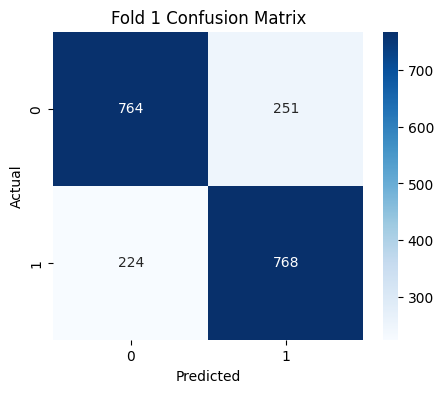

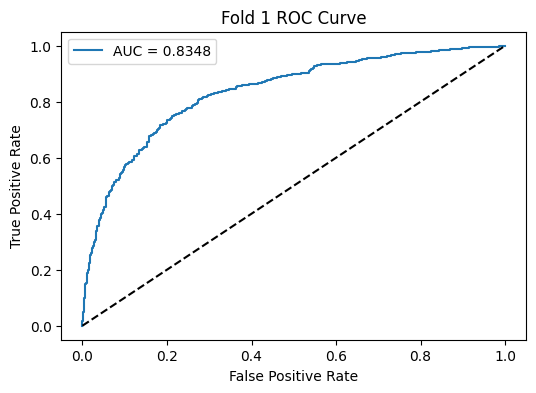


----- Fold 2 Evaluation -----
63/63 ━━━━━━━━━━━━━━━━━━━━ 29s 434ms/step
Accuracy:  0.8017
Precision: 0.7756
Recall:    0.8225
F1-score:  0.7984
AUC:       0.8792


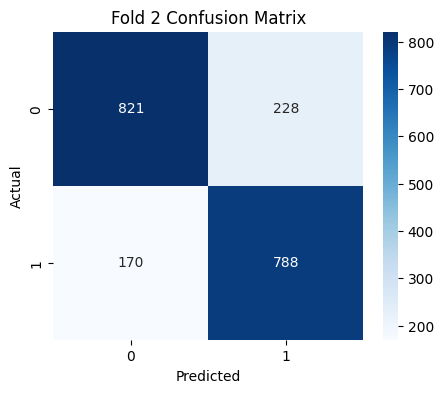

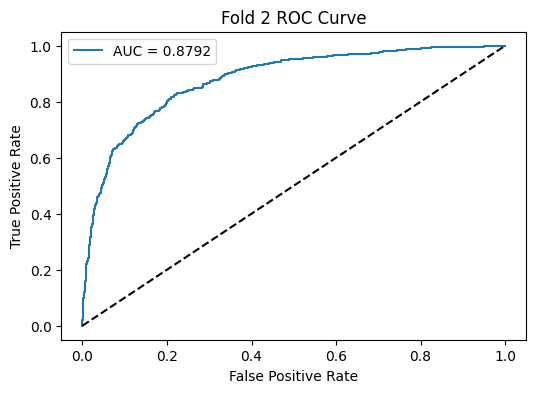


----- Fold 3 Evaluation -----
63/63 ━━━━━━━━━━━━━━━━━━━━ 28s 414ms/step
Accuracy:  0.8056
Precision: 0.7803
Recall:    0.8490
F1-score:  0.8132
AUC:       0.8869


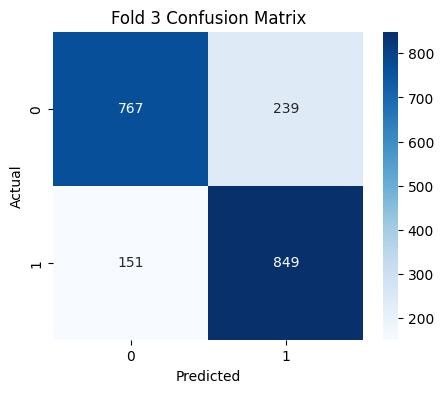

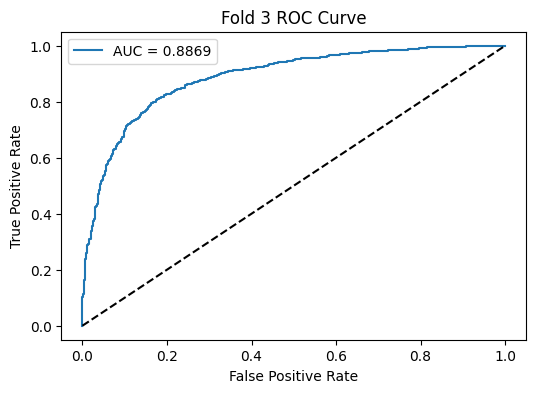


----- Fold 4 Evaluation -----
63/63 ━━━━━━━━━━━━━━━━━━━━ 26s 388ms/step
Accuracy:  0.8265
Precision: 0.8322
Recall:    0.8354
F1-score:  0.8338
AUC:       0.9074


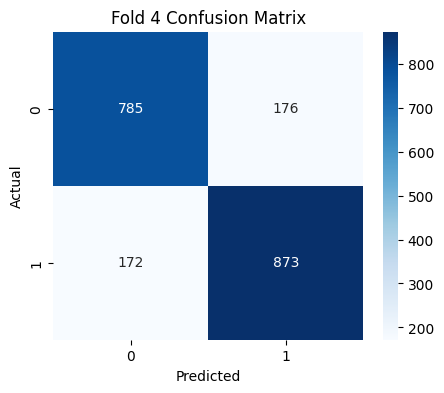

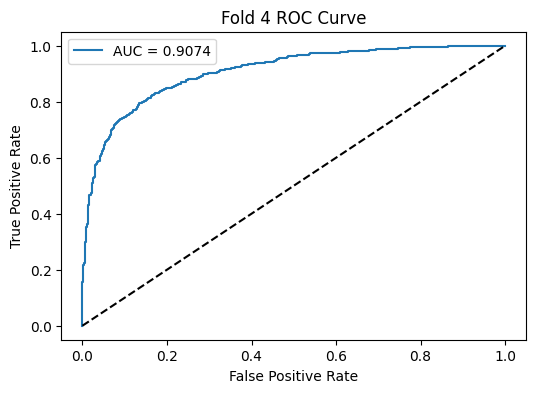


----- Fold 5 Evaluation -----
63/63 ━━━━━━━━━━━━━━━━━━━━ 27s 414ms/step
Accuracy:  0.8495
Precision: 0.8307
Recall:    0.8844
F1-score:  0.8567
AUC:       0.9157


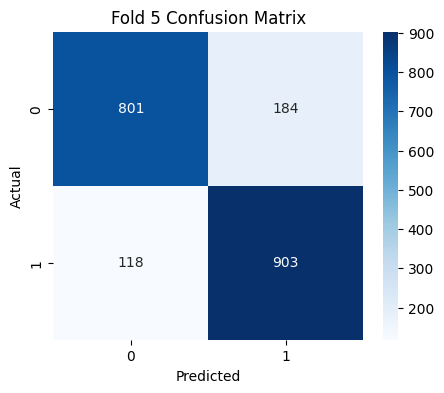

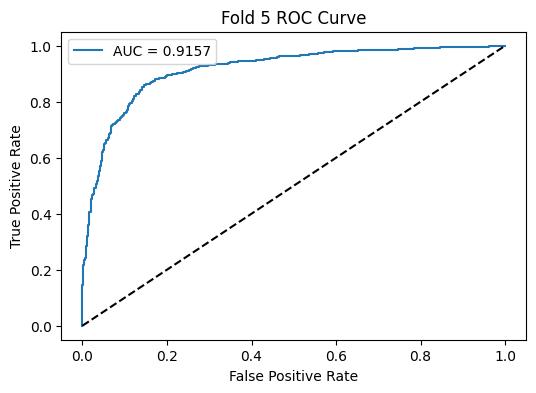


Best model: /content/drive/MyDrive/deepfake_models/fold_1_epoch_05.keras
Best Validation Accuracy: 0.8494516450648056


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
import seaborn as sns
import pandas as pd # Import pandas for DataFrame
import os # Import os for path operations
import tensorflow as tf # Import tensorflow for model loading

print("\n==================== EVALUATION METRICS ====================\n")

fold_metrics = []

fold_no = 0
best_val_acc = -1
best_model_path = None

# Get model paths
model_files = sorted([f for f in os.listdir(MODEL_DIR) if f.endswith(".keras")])
models_paths = [os.path.join(MODEL_DIR, mf) for mf in model_files]

for train_idx, val_idx in kfold.split(X):
    fold_no += 1
    print(f"\n----- Fold {fold_no} Evaluation -----")

    # Ensure we don't go out of bounds if fewer models than folds were saved
    if fold_no - 1 >= len(models_paths):
        print(f"No model found for Fold {fold_no}. Skipping evaluation for this fold.")
        continue

    model_path = models_paths[fold_no-1]
    model = tf.keras.models.load_model(model_path)

    val_images = X[val_idx]
    y_true_val = y[val_idx]

    # Predictions
    # Direct prediction on NumPy array X_val_fold instead of flow_from_dataframe
    preds = model.predict(val_images)
    preds_bin = (preds >= 0.5).astype(int).reshape(-1)

    y_pred = preds_bin

    # Metrics
    acc  = accuracy_score(y_true_val, y_pred)
    prec = precision_score(y_true_val, y_pred)
    rec  = recall_score(y_true_val, y_pred)
    f1   = f1_score(y_true_val, y_pred)

    # ROC-AUC
    fpr, tpr, _ = roc_curve(y_true_val, preds)
    roc_auc = auc(fpr, tpr)

    print(f"Accuracy:  {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"F1-score:  {f1:.4f}")
    print(f"AUC:       {roc_auc:.4f}")

    fold_metrics.append([acc, prec, rec, f1, roc_auc])

    # Confusion Matrix
    plt.figure(figsize=(5,4))
    sns.heatmap(confusion_matrix(y_true_val, y_pred), annot=True, fmt="d", cmap="Blues")
    plt.title(f"Fold {fold_no} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # ROC Curve Plot
    plt.figure(figsize=(6,4))
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
    plt.plot([0,1], [0,1], 'k--')
    plt.title(f"Fold {fold_no} ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.show()

    # Track the best model
    if acc > best_val_acc:
        best_val_acc = acc
        best_model_path = model_path

print("\nBest model:", best_model_path)
print("Best Validation Accuracy:", best_val_acc)

In [ ]:
import numpy as np

fold_metrics = np.array(fold_metrics)

avg_accuracy  = fold_metrics[:,0].mean()
avg_precision = fold_metrics[:,1].mean()
avg_recall    = fold_metrics[:,2].mean()
avg_f1        = fold_metrics[:,3].mean()
avg_auc       = fold_metrics[:,4].mean()

print("\n==================== OVERALL METRICS (Across All Folds) ====================\n")
print(f"Overall Accuracy:  {avg_accuracy:.4f}")
print(f"Overall Precision: {avg_precision:.4f}")
print(f"Overall Recall:    {avg_recall:.4f}")
print(f"Overall F1-score:  {avg_f1:.4f}")
print(f"Overall AUC:       {avg_auc:.4f}")



==================== OVERALL METRICS (Across All Folds) ====================

Overall Accuracy:  0.8093
Overall Precision: 0.7945
Overall Recall:    0.8331
Overall F1-score:  0.8132
Overall AUC:       0.8848


In [ ]:
import re
import numpy as np

output_cell_5KmAxGB4aztD = """
========== FOLD 1 ==========
Epoch 1/15
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m94s0m 694ms/step - accuracy: 0.5991 - loss: 0.9511 - val_accuracy: 0.7490 - val_loss: 0.7508
Epoch 2/15
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m63s0m 502ms/step - accuracy: 0.7247 - loss: 0.7700 - val_accuracy: 0.7779 - val_loss: 0.7028
Epoch 3/15
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m63s0m 499ms/step - accuracy: 0.7570 - loss: 0.7162 - val_accuracy: 0.7898 - val_loss: 0.6766
Epoch 4/15
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m64s0m 510ms/step - accuracy: 0.7765 - loss: 0.6815 - val_accuracy: 0.8058 - val_loss: 0.6520
Epoch 5/15
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m70s0m 556ms/step - accuracy: 0.8135 - loss: 0.6418 - val_accuracy: 0.8018 - val_loss: 0.6409
Epoch 6/15
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m70s0m 559ms/step - accuracy: 0.8253 - loss: 0.6040 - val_accuracy: 0.8277 - val_loss: 0.6167
Epoch 7/15
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m83s0m 569ms/step - accuracy: 0.8281 - loss: 0.5953 - val_accuracy: 0.8048 - val_loss: 0.6195
Epoch 8/15
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m62s0m 493ms/step - accuracy: 0.8314 - loss: 0.5684 - val_accuracy: 0.8267 - val_loss: 0.6003
Epoch 9/15
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m70s0m 554ms/step - accuracy: 0.8362 - loss: 0.5458 - val_accuracy: 0.8247 - val_loss: 0.5948
Epoch 10/15
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m62s0m 493ms/step - accuracy: 0.8628 - loss: 0.5216 - val_accuracy: 0.8257 - val_loss: 0.5827
Epoch 11/15
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m71s0m 564ms/step - accuracy: 0.8603 - loss: 0.5156 - val_accuracy: 0.8367 - val_loss: 0.5758
Epoch 12/15
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m82s0m 566ms/step - accuracy: 0.8684 - loss: 0.5078 - val_accuracy: 0.8327 - val_loss: 0.5671
Epoch 13/15
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m82s0m 568ms/step - accuracy: 0.8729 - loss: 0.4926 - val_accuracy: 0.8247 - val_loss: 0.5621
Epoch 14/15
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m64s0m 509ms/step - accuracy: 0.8902 - loss: 0.4592 - val_accuracy: 0.8376 - val_loss: 0.5565
Epoch 15/15
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m73s0m 580ms/step - accuracy: 0.8784 - loss: 0.4731 - val_accuracy: 0.8247 - val_loss: 0.5579
1m32/320m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m16s0m 427ms/step
Fold 1 Accuracy: 0.8376494023904383
Fold 1 AUC: 0.9094887203701054
[[456  66]
 [ 97 385]]
              precision    recall  f1-score   support

           0       0.82      0.87      0.85       522
           1       0.85      0.80      0.83       482

    accuracy                           0.84      1004
   macro avg       0.84      0.84      0.84      1004
weighted avg       0.84      0.84      0.84      1004


========== FOLD 2 ==========
Epoch 1/15
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m72s0m 532ms/step - accuracy: 0.5433 - loss: 1.1297 - val_accuracy: 0.7567 - val_loss: 0.7347
Epoch 2/15
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m85s0m 560ms/step - accuracy: 0.7093 - loss: 0.8074 - val_accuracy: 0.8026 - val_loss: 0.6814
Epoch 3/15
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m63s0m 500ms/step - accuracy: 0.7360 - loss: 0.7302 - val_accuracy: 0.8156 - val_loss: 0.6462
Epoch 4/15
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m65s0m 514ms/step - accuracy: 0.7729 - loss: 0.6904 - val_accuracy: 0.8265 - val_loss: 0.6219
Epoch 5/15
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m62s0m 493ms/step - accuracy: 0.7921 - loss: 0.6678 - val_accuracy: 0.8146 - val_loss: 0.6163
Epoch 6/15
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m70s0m 555ms/step - accuracy: 0.8004 - loss: 0.6325 - val_accuracy: 0.8395 - val_loss: 0.5953
Epoch 7/15
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m75s0m 500ms/step - accuracy: 0.8182 - loss: 0.6079 - val_accuracy: 0.8325 - val_loss: 0.5852
Epoch 8/15
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m72s0m 574ms/step - accuracy: 0.8402 - loss: 0.5769 - val_accuracy: 0.8245 - val_loss: 0.5748
Epoch 9/15
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m72s0m 498ms/step - accuracy: 0.8427 - loss: 0.5608 - val_accuracy: 0.8355 - val_loss: 0.5630
Epoch 10/15
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m64s0m 504ms/step - accuracy: 0.8451 - loss: 0.5431 - val_accuracy: 0.8325 - val_loss: 0.5508
Epoch 11/15
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m91s0m 577ms/step - accuracy: 0.8483 - loss: 0.5306 - val_accuracy: 0.8425 - val_loss: 0.5432
Epoch 12/15
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m73s0m 502ms/step - accuracy: 0.8566 - loss: 0.5165 - val_accuracy: 0.8445 - val_loss: 0.5395
Epoch 13/15
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m90s0m 566ms/step - accuracy: 0.8645 - loss: 0.4977 - val_accuracy: 0.8425 - val_loss: 0.5324
Epoch 14/15
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m81s0m 560ms/step - accuracy: 0.8804 - loss: 0.4756 - val_accuracy: 0.8495 - val_loss: 0.5266
Epoch 15/15
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m70s0m 561ms/step - accuracy: 0.8697 - loss: 0.4878 - val_accuracy: 0.8534 - val_loss: 0.5227
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m70s0m 561ms/step - accuracy: 0.8697 - loss: 0.4878 - val_accuracy: 0.8534 - val_loss: 0.5227
1m32/320m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m15s0m 436ms/step
1m32/320m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m15s0m 436ms/step
Fold 2 Accuracy: 0.8534396809571286
Fold 2 AUC: 0.9271095980846782
[[432  77]
 [ 70 424]]
              precision    recall  f1-score   support

           0       0.86      0.85      0.85       509
           1       0.85      0.86      0.85       494

    accuracy                           0.85      1003
   macro avg       0.85      0.85      0.85      1003
weighted avg       0.85      0.85      0.85      1003


========== FOLD 3 ==========
Fold 2 Accuracy: 0.8534396809571286
Fold 2 AUC: 0.9271095980846782
[[432  77]
 [ 70 424]]
              precision    recall  f1-score   support

           0       0.86      0.85      0.85       509
           1       0.85      0.86      0.85       494

    accuracy                           0.85      1003
   macro avg       0.85      0.85      0.85      1003
weighted avg       0.85      0.85      0.85      1003


========== FOLD 3 ==========
Epoch 1/15
Epoch 1/15
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m71s0m 518ms/step - accuracy: 0.5335 - loss: 1.0640 - val_accuracy: 0.7368 - val_loss: 0.7686
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m71s0m 518ms/step - accuracy: 0.5335 - loss: 1.0640 - val_accuracy: 0.7368 - val_loss: 0.7686
Epoch 2/15
Epoch 2/15
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m87s0m 556ms/step - accuracy: 0.7167 - loss: 0.7739 - val_accuracy: 0.7757 - val_loss: 0.7182
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m87s0m 556ms/step - accuracy: 0.7167 - loss: 0.7739 - val_accuracy: 0.7757 - val_loss: 0.7182
Epoch 3/15
Epoch 3/15
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m83s0m 563ms/step - accuracy: 0.7659 - loss: 0.7220 - val_accuracy: 0.7777 - val_loss: 0.6940
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m83s0m 563ms/step - accuracy: 0.7659 - loss: 0.7220 - val_accuracy: 0.7777 - val_loss: 0.6940
Epoch 4/15
Epoch 4/15
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m63s0m 501ms/step - accuracy: 0.7708 - loss: 0.6912 - val_accuracy: 0.7866 - val_loss: 0.6713
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m63s0m 501ms/step - accuracy: 0.7708 - loss: 0.6912 - val_accuracy: 0.7866 - val_loss: 0.6713
Epoch 5/15
Epoch 5/15
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m72s0m 576ms/step - accuracy: 0.8090 - loss: 0.6304 - val_accuracy: 0.7946 - val_loss: 0.6538
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m72s0m 576ms/step - accuracy: 0.8090 - loss: 0.6304 - val_accuracy: 0.7946 - val_loss: 0.6538
Epoch 6/15
Epoch 6/15
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m64s0m 510ms/step - accuracy: 0.8102 - loss: 0.6153 - val_accuracy: 0.7946 - val_loss: 0.6439
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m64s0m 510ms/step - accuracy: 0.8102 - loss: 0.6153 - val_accuracy: 0.7946 - val_loss: 0.6439
Epoch 7/15
Epoch 7/15
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m71s0m 563ms/step - accuracy: 0.8154 - loss: 0.5957 - val_accuracy: 0.8066 - val_loss: 0.6289
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m71s0m 563ms/step - accuracy: 0.8154 - loss: 0.5957 - val_accuracy: 0.8066 - val_loss: 0.6289
Epoch 8/15
Epoch 8/15
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m85s0m 585ms/step - accuracy: 0.8328 - loss: 0.5606 - val_accuracy: 0.8026 - val_loss: 0.6172
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m85s0m 585ms/step - accuracy: 0.8328 - loss: 0.5606 - val_accuracy: 0.8026 - val_loss: 0.6172
Epoch 9/15
Epoch 9/15
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m74s0m 526ms/step - accuracy: 0.8425 - loss: 0.5457 - val_accuracy: 0.8086 - val_loss: 0.6111
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m74s0m 526ms/step - accuracy: 0.8425 - loss: 0.5457 - val_accuracy: 0.8086 - val_loss: 0.6111
Epoch 10/15
Epoch 10/15
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m80s0m 513ms/step - accuracy: 0.8536 - loss: 0.5328 - val_accuracy: 0.8116 - val_loss: 0.6017
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m80s0m 513ms/step - accuracy: 0.8536 - loss: 0.5328 - val_accuracy: 0.8116 - val_loss: 0.6017
Epoch 11/15
Epoch 11/15
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m72s0m 574ms/step - accuracy: 0.8639 - loss: 0.5129 - val_accuracy: 0.8116 - val_loss: 0.5970
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m72s0m 574ms/step - accuracy: 0.8639 - loss: 0.5129 - val_accuracy: 0.8116 - val_loss: 0.5970
Epoch 12/15
Epoch 12/15
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m72s0m 570ms/step - accuracy: 0.8584 - loss: 0.5072 - val_accuracy: 0.8156 - val_loss: 0.5831
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m72s0m 570ms/step - accuracy: 0.8584 - loss: 0.5072 - val_accuracy: 0.8156 - val_loss: 0.5831
Epoch 13/15
Epoch 13/15
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m72s0m 572ms/step - accuracy: 0.8658 - loss: 0.4967 - val_accuracy: 0.8205 - val_loss: 0.5808
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m72s0m 572ms/step - accuracy: 0.8658 - loss: 0.4967 - val_accuracy: 0.8205 - val_loss: 0.5808
Epoch 14/15
Epoch 14/15
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m72s0m 568ms/step - accuracy: 0.8869 - loss: 0.4670 - val_accuracy: 0.8146 - val_loss: 0.5758
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m72s0m 568ms/step - accuracy: 0.8869 - loss: 0.4670 - val_accuracy: 0.8146 - val_loss: 0.5758
Epoch 15/15
Epoch 15/15
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m71s0m 564ms/step - accuracy: 0.8725 - loss: 0.4685 - val_accuracy: 0.8146 - val_loss: 0.5689
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m71s0m 564ms/step - accuracy: 0.8725 - loss: 0.4685 - val_accuracy: 0.8146 - val_loss: 0.5689
1m32/320m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m16s0m 452ms/step
1m32/320m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m16s0m 452ms/step
Fold 3 Accuracy: 0.8145563310069791
Fold 3 AUC: 0.8964554242749732
[[398  92]
 [ 94 419]]
              precision    recall  f1-score   support

           0       0.81      0.81      0.81       490
           1       0.82      0.82      0.82       513

    accuracy                           0.81      1003
   macro avg       0.81      0.81      0.81      1003
weighted avg       0.81      0.81      0.81      1003


========== FOLD 4 ==========
Fold 3 Accuracy: 0.8145563310069791
Fold 3 AUC: 0.8964554242749732
[[398  92]
 [ 94 419]]
              precision    recall  f1-score   support

           0       0.81      0.81      0.81       490
           1       0.82      0.82      0.82       513

    accuracy                           0.81      1003
   macro avg       0.81      0.81      0.81      1003
weighted avg       0.81      0.81      0.81      1003


========== FOLD 4 ==========
Epoch 1/15
Epoch 1/15
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m71s0m 511ms/step - accuracy: 0.5768 - loss: 0.9646 - val_accuracy: 0.7468 - val_loss: 0.7348
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m71s0m 511ms/step - accuracy: 0.5768 - loss: 0.9646 - val_accuracy: 0.7468 - val_loss: 0.7348
Epoch 2/15
Epoch 2/15
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m64s0m 511ms/step - accuracy: 0.7236 - loss: 0.7624 - val_accuracy: 0.7707 - val_loss: 0.6927
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m64s0m 511ms/step - accuracy: 0.7236 - loss: 0.7624 - val_accuracy: 0.7707 - val_loss: 0.6927
Epoch 3/15
Epoch 3/15
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m89s0m 565ms/step - accuracy: 0.7597 - loss: 0.7082 - val_accuracy: 0.7876 - val_loss: 0.6663
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m89s0m 565ms/step - accuracy: 0.7597 - loss: 0.7082 - val_accuracy: 0.7876 - val_loss: 0.6663
Epoch 4/15
Epoch 4/15
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m73s0m 496ms/step - accuracy: 0.7923 - loss: 0.6529 - val_accuracy: 0.7976 - val_loss: 0.6410
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m73s0m 496ms/step - accuracy: 0.7923 - loss: 0.6529 - val_accuracy: 0.7976 - val_loss: 0.6410
Epoch 5/15
Epoch 5/15
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m63s0m 498ms/step - accuracy: 0.8094 - loss: 0.6288 - val_accuracy: 0.8036 - val_loss: 0.6317
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m63s0m 498ms/step - accuracy: 0.8094 - loss: 0.6288 - val_accuracy: 0.8036 - val_loss: 0.6317
Epoch 6/15
Epoch 6/15
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m91s0m 569ms/step - accuracy: 0.8123 - loss: 0.6101 - val_accuracy: 0.8166 - val_loss: 0.6111
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m91s0m 569ms/step - accuracy: 0.8123 - loss: 0.6101 - val_accuracy: 0.8166 - val_loss: 0.6111
Epoch 7/15
Epoch 7/15
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m73s0m 582ms/step - accuracy: 0.8184 - loss: 0.6016 - val_accuracy: 0.8166 - val_loss: 0.6000
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m73s0m 582ms/step - accuracy: 0.8184 - loss: 0.6016 - val_accuracy: 0.8166 - val_loss: 0.6000
Epoch 8/15
Epoch 8/15
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m80s0m 566ms/step - accuracy: 0.8429 - loss: 0.5596 - val_accuracy: 0.8235 - val_loss: 0.5880
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m80s0m 566ms/step - accuracy: 0.8429 - loss: 0.5596 - val_accuracy: 0.8235 - val_loss: 0.5880
Epoch 9/15
Epoch 9/15
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m63s0m 502ms/step - accuracy: 0.8472 - loss: 0.5437 - val_accuracy: 0.8225 - val_loss: 0.5805
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m63s0m 502ms/step - accuracy: 0.8472 - loss: 0.5437 - val_accuracy: 0.8225 - val_loss: 0.5805
Epoch 10/15
Epoch 10/15
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m90s0m 569ms/step - accuracy: 0.8500 - loss: 0.5336 - val_accuracy: 0.8146 - val_loss: 0.5806
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m90s0m 569ms/step - accuracy: 0.8500 - loss: 0.5336 - val_accuracy: 0.8146 - val_loss: 0.5806
Epoch 11/15
Epoch 11/15
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m71s0m 565ms/step - accuracy: 0.8610 - loss: 0.5126 - val_accuracy: 0.8315 - val_loss: 0.5664
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m71s0m 565ms/step - accuracy: 0.8610 - loss: 0.5126 - val_accuracy: 0.8315 - val_loss: 0.5664
Epoch 12/15
Epoch 12/15
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m81s0m 557ms/step - accuracy: 0.8614 - loss: 0.5070 - val_accuracy: 0.8146 - val_loss: 0.5729
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m81s0m 557ms/step - accuracy: 0.8614 - loss: 0.5070 - val_accuracy: 0.8146 - val_loss: 0.5729
Epoch 13/15
Epoch 13/15
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m71s0m 568ms/step - accuracy: 0.8707 - loss: 0.4863 - val_accuracy: 0.8305 - val_loss: 0.5527
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m71s0m 568ms/step - accuracy: 0.8707 - loss: 0.4863 - val_accuracy: 0.8305 - val_loss: 0.5527
Epoch 14/15
Epoch 14/15
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m71s0m 564ms/step - accuracy: 0.8788 - loss: 0.4883 - val_accuracy: 0.8355 - val_loss: 0.5487
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m71s0m 564ms/step - accuracy: 0.8788 - loss: 0.4883 - val_accuracy: 0.8355 - val_loss: 0.5487
Epoch 15/15
Epoch 15/15
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m85s0m 585ms/step - accuracy: 0.8912 - loss: 0.4501 - val_accuracy: 0.8405 - val_loss: 0.5443
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m85s0m 585ms/step - accuracy: 0.8912 - loss: 0.4501 - val_accuracy: 0.8405 - val_loss: 0.5443
1m32/320m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m15s0m 436ms/step
1m32/320m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m15s0m 436ms/step
Fold 4 Accuracy: 0.8404785643070788
Fold 4 AUC: 0.9113102055099573
[[441  66]
 [ 94 402]]
              precision    recall  f1-score   support

           0       0.82      0.87      0.85       507
           1       0.86      0.81      0.83       496

    accuracy                           0.84      1003
   macro avg       0.84      0.84      0.84      1003
weighted avg       0.84      0.84      0.84      1003


========== FOLD 5 ==========
Fold 4 Accuracy: 0.8404785643070788
Fold 4 AUC: 0.9113102055099573
[[441  66]
 [ 94 402]]
              precision    recall  f1-score   support

           0       0.82      0.87      0.85       507
           1       0.86      0.81      0.83       496

    accuracy                           0.84      1003
   macro avg       0.84      0.84      0.84      1003
weighted avg       0.84      0.84      0.84      1003


========== FOLD 5 ==========
Epoch 1/15
Epoch 1/15
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m79s0m 576ms/step - accuracy: 0.5603 - loss: 1.0174 - val_accuracy: 0.7537 - val_loss: 0.7742
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m79s0m 576ms/step - accuracy: 0.5603 - loss: 1.0174 - val_accuracy: 0.7537 - val_loss: 0.7742
Epoch 2/15
Epoch 2/15
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m82s0m 578ms/step - accuracy: 0.7134 - loss: 0.7724 - val_accuracy: 0.7647 - val_loss: 0.7279
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m82s0m 578ms/step - accuracy: 0.7134 - loss: 0.7724 - val_accuracy: 0.7647 - val_loss: 0.7279
Epoch 3/15
Epoch 3/15
1m 14/1260m 32m━━0m37m━━━━━━━━━━━━━━━━━━0m 1m41s0m 367ms/step - accuracy: 0.7512 - loss: 0.7230
"""

accuracy_scores = []
auc_scores = []

# Regex to clean up ANSI escape codes and repeated lines
clean_line_regex = re.compile(r'\x1b\[[0-9;]*m')

# Regex to find 'Fold X Accuracy: Y' and 'Fold X AUC: Z'
accuracy_regex = re.compile(r'Fold \d+ Accuracy: ([0-9.]+)')
auc_regex = re.compile(r'Fold \d+ AUC: ([0-9.]+)')

lines = output_cell_5KmAxGB4aztD.split('\n')

for line in lines:
    cleaned_line = clean_line_regex.sub('', line)

    acc_match = accuracy_regex.search(cleaned_line)
    if acc_match:
        accuracy_scores.append(float(acc_match.group(1)))

    auc_match = auc_regex.search(cleaned_line)
    if auc_match:
        auc_scores.append(float(auc_match.group(1)))

# Calculate averages
if accuracy_scores:
    avg_accuracy = np.mean(accuracy_scores)
    print(f"Average Accuracy across folds: {avg_accuracy:.4f}")
else:
    print("No accuracy scores found.")

if auc_scores:
    avg_auc = np.mean(auc_scores)
    print(f"Average AUC across folds: {avg_auc:.4f}")
else:
    print("No AUC scores found.")


Average Accuracy across folds: 0.8364
Average AUC across folds: 0.9113


In [ ]:
import re

output = """========== FOLD 1 ==========
Epoch 1/15
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m94s0m 694ms/step - accuracy: 0.5991 - loss: 0.9511 - val_accuracy: 0.7490 - val_loss: 0.7508
Epoch 2/15
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m63s0m 502ms/step - accuracy: 0.7247 - loss: 0.7700 - val_accuracy: 0.7779 - val_loss: 0.7028
Epoch 3/15
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m63s0m 499ms/step - accuracy: 0.7570 - loss: 0.7162 - val_accuracy: 0.7898 - val_loss: 0.6766
Epoch 4/15
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m64s0m 510ms/step - accuracy: 0.7765 - loss: 0.6815 - val_accuracy: 0.8058 - val_loss: 0.6520
Epoch 5/15
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m70s0m 556ms/step - accuracy: 0.8135 - loss: 0.6418 - val_accuracy: 0.8018 - val_loss: 0.6409
Epoch 6/15
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m70s0m 559ms/step - accuracy: 0.8253 - loss: 0.6040 - val_accuracy: 0.8277 - val_loss: 0.6167
Epoch 7/15
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m83s0m 569ms/step - accuracy: 0.8281 - loss: 0.5953 - val_accuracy: 0.8048 - val_loss: 0.6195
Epoch 8/15
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m62s0m 493ms/step - accuracy: 0.8314 - loss: 0.5684 - val_accuracy: 0.8267 - val_loss: 0.6003
Epoch 9/15
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m70s0m 554ms/step - accuracy: 0.8362 - loss: 0.5458 - val_accuracy: 0.8247 - val_loss: 0.5948
Epoch 10/15
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m62s0m 493ms/step - accuracy: 0.8628 - loss: 0.5216 - val_accuracy: 0.8257 - val_loss: 0.5827
Epoch 11/15
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m71s0m 564ms/step - accuracy: 0.8603 - loss: 0.5156 - val_accuracy: 0.8367 - val_loss: 0.5758
Epoch 12/15
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m82s0m 566ms/step - accuracy: 0.8684 - loss: 0.5078 - val_accuracy: 0.8327 - val_loss: 0.5671
Epoch 13/15
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m82s0m 568ms/step - accuracy: 0.8729 - loss: 0.4926 - val_accuracy: 0.8247 - val_loss: 0.5621
Epoch 14/15
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m64s0m 509ms/step - accuracy: 0.8902 - loss: 0.4592 - val_accuracy: 0.8376 - val_loss: 0.5565
Epoch 15/15
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m73s0m 580ms/step - accuracy: 0.8784 - loss: 0.4731 - val_accuracy: 0.8247 - val_loss: 0.5579
1m32/320m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m16s0m 427ms/step
Fold 1 Accuracy: 0.8376494023904383
Fold 1 AUC: 0.9094887203701054
[[456  66]
 [ 97 385]]
              precision    recall  f1-score   support

           0       0.82      0.87      0.85       522
           1       0.85      0.80      0.83       482

    accuracy                           0.84      1004
   macro avg       0.84      0.84      0.84      1004
weighted avg       0.84      0.84      0.84      1004


========== FOLD 2 ==========
Epoch 1/15
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m72s0m 532ms/step - accuracy: 0.5433 - loss: 1.1297 - val_accuracy: 0.7567 - val_loss: 0.7347
Epoch 2/15
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m85s0m 560ms/step - accuracy: 0.7093 - loss: 0.8074 - val_accuracy: 0.8026 - val_loss: 0.6814
Epoch 3/15
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m63s0m 500ms/step - accuracy: 0.7360 - loss: 0.7302 - val_accuracy: 0.8156 - val_loss: 0.6462
Epoch 4/15
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m65s0m 514ms/step - accuracy: 0.7729 - loss: 0.6904 - val_accuracy: 0.8265 - val_loss: 0.6219
Epoch 5/15
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m62s0m 493ms/step - accuracy: 0.7921 - loss: 0.6678 - val_accuracy: 0.8146 - val_loss: 0.6163
Epoch 6/15
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m70s0m 555ms/step - accuracy: 0.8004 - loss: 0.6325 - val_accuracy: 0.8395 - val_loss: 0.5953
Epoch 7/15
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m75s0m 500ms/step - accuracy: 0.8182 - loss: 0.6079 - val_accuracy: 0.8325 - val_loss: 0.5852
Epoch 8/15
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m72s0m 574ms/step - accuracy: 0.8402 - loss: 0.5769 - val_accuracy: 0.8245 - val_loss: 0.5748
Epoch 9/15
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m72s0m 498ms/step - accuracy: 0.8427 - loss: 0.5608 - val_accuracy: 0.8355 - val_loss: 0.5630
Epoch 10/15
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m64s0m 504ms/step - accuracy: 0.8451 - loss: 0.5431 - val_accuracy: 0.8325 - val_loss: 0.5508
Epoch 11/15
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m91s0m 577ms/step - accuracy: 0.8483 - loss: 0.5306 - val_accuracy: 0.8425 - val_loss: 0.5432
Epoch 12/15
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m73s0m 502ms/step - accuracy: 0.8566 - loss: 0.5165 - val_accuracy: 0.8445 - val_loss: 0.5395
Epoch 13/15
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m90s0m 566ms/step - accuracy: 0.8645 - loss: 0.4977 - val_accuracy: 0.8425 - val_loss: 0.5324
Epoch 14/15
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m81s0m 560ms/step - accuracy: 0.8804 - loss: 0.4756 - val_accuracy: 0.8495 - val_loss: 0.5266
Epoch 15/15
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m70s0m 561ms/step - accuracy: 0.8697 - loss: 0.4878 - val_accuracy: 0.8534 - val_loss: 0.5227
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m70s0m 561ms/step - accuracy: 0.8697 - loss: 0.4878 - val_accuracy: 0.8534 - val_loss: 0.5227
1m32/320m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m15s0m 436ms/step
1m32/320m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m15s0m 436ms/step
Fold 2 Accuracy: 0.8534396809571286
Fold 2 AUC: 0.9271095980846782
[[432  77]
 [ 70 424]]
              precision    recall  f1-score   support

           0       0.86      0.85      0.85       509
           1       0.85      0.86      0.85       494

    accuracy                           0.85      1003
   macro avg       0.85      0.85      0.85      1003
weighted avg       0.85      0.85      0.85      1003


========== FOLD 3 ==========
Fold 2 Accuracy: 0.8534396809571286
Fold 2 AUC: 0.9271095980846782
[[432  77]
 [ 70 424]]
              precision    recall  f1-score   support

           0       0.86      0.85      0.85       509
           1       0.85      0.86      0.85       494

    accuracy                           0.85      1003
   macro avg       0.85      0.85      0.85      1003
weighted avg       0.85      0.85      0.85      1003


========== FOLD 3 ==========
Epoch 1/15
Epoch 1/15
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m71s0m 518ms/step - accuracy: 0.5335 - loss: 1.0640 - val_accuracy: 0.7368 - val_loss: 0.7686
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m71s0m 518ms/step - accuracy: 0.5335 - loss: 1.0640 - val_accuracy: 0.7368 - val_loss: 0.7686
Epoch 2/15
Epoch 2/15
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m87s0m 556ms/step - accuracy: 0.7167 - loss: 0.7739 - val_accuracy: 0.7757 - val_loss: 0.7182
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m87s0m 556ms/step - accuracy: 0.7167 - loss: 0.7739 - val_accuracy: 0.7757 - val_loss: 0.7182
Epoch 3/15
Epoch 3/15
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m83s0m 563ms/step - accuracy: 0.7659 - loss: 0.7220 - val_accuracy: 0.7777 - val_loss: 0.6940
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m83s0m 563ms/step - accuracy: 0.7659 - loss: 0.7220 - val_accuracy: 0.7777 - val_loss: 0.6940
Epoch 4/15
Epoch 4/15
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m63s0m 501ms/step - accuracy: 0.7708 - loss: 0.6912 - val_accuracy: 0.7866 - val_loss: 0.6713
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m63s0m 501ms/step - accuracy: 0.7708 - loss: 0.6912 - val_accuracy: 0.7866 - val_loss: 0.6713
Epoch 5/15
Epoch 5/15
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m72s0m 576ms/step - accuracy: 0.8090 - loss: 0.6304 - val_accuracy: 0.7946 - val_loss: 0.6538
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m72s0m 576ms/step - accuracy: 0.8090 - loss: 0.6304 - val_accuracy: 0.7946 - val_loss: 0.6538
Epoch 6/15
Epoch 6/15
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m64s0m 510ms/step - accuracy: 0.8102 - loss: 0.6153 - val_accuracy: 0.7946 - val_loss: 0.6439
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m64s0m 510ms/step - accuracy: 0.8102 - loss: 0.6153 - val_accuracy: 0.7946 - val_loss: 0.6439
Epoch 7/15
Epoch 7/15
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m71s0m 563ms/step - accuracy: 0.8154 - loss: 0.5957 - val_accuracy: 0.8066 - val_loss: 0.6289
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m71s0m 563ms/step - accuracy: 0.8154 - loss: 0.5957 - val_accuracy: 0.8066 - val_loss: 0.6289
Epoch 8/15
Epoch 8/15
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m85s0m 585ms/step - accuracy: 0.8328 - loss: 0.5606 - val_accuracy: 0.8026 - val_loss: 0.6172
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m85s0m 585ms/step - accuracy: 0.8328 - loss: 0.5606 - val_accuracy: 0.8026 - val_loss: 0.6172
Epoch 9/15
Epoch 9/15
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m74s0m 526ms/step - accuracy: 0.8425 - loss: 0.5457 - val_accuracy: 0.8086 - val_loss: 0.6111
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m74s0m 526ms/step - accuracy: 0.8425 - loss: 0.5457 - val_accuracy: 0.8086 - val_loss: 0.6111
Epoch 10/15
Epoch 10/15
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m80s0m 513ms/step - accuracy: 0.8536 - loss: 0.5328 - val_accuracy: 0.8116 - val_loss: 0.6017
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m80s0m 513ms/step - accuracy: 0.8536 - loss: 0.5328 - val_accuracy: 0.8116 - val_loss: 0.6017
Epoch 11/15
Epoch 11/15
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m72s0m 574ms/step - accuracy: 0.8639 - loss: 0.5129 - val_accuracy: 0.8116 - val_loss: 0.5970
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m72s0m 574ms/step - accuracy: 0.8639 - loss: 0.5129 - val_accuracy: 0.8116 - val_loss: 0.5970
Epoch 12/15
Epoch 12/15
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m72s0m 570ms/step - accuracy: 0.8584 - loss: 0.5072 - val_accuracy: 0.8156 - val_loss: 0.5831
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m72s0m 570ms/step - accuracy: 0.8584 - loss: 0.5072 - val_accuracy: 0.8156 - val_loss: 0.5831
Epoch 13/15
Epoch 13/15
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m72s0m 572ms/step - accuracy: 0.8658 - loss: 0.4967 - val_accuracy: 0.8205 - val_loss: 0.5808
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m72s0m 572ms/step - accuracy: 0.8658 - loss: 0.4967 - val_accuracy: 0.8205 - val_loss: 0.5808
Epoch 14/15
Epoch 14/15
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m72s0m 568ms/step - accuracy: 0.8869 - loss: 0.4670 - val_accuracy: 0.8146 - val_loss: 0.5758
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m72s0m 568ms/step - accuracy: 0.8869 - loss: 0.4670 - val_accuracy: 0.8146 - val_loss: 0.5758
Epoch 15/15
Epoch 15/15
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m71s0m 564ms/step - accuracy: 0.8725 - loss: 0.4685 - val_accuracy: 0.8146 - val_loss: 0.5689
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m71s0m 564ms/step - accuracy: 0.8725 - loss: 0.4685 - val_accuracy: 0.8146 - val_loss: 0.5689
1m32/320m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m16s0m 452ms/step
1m32/320m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m16s0m 452ms/step
Fold 3 Accuracy: 0.8145563310069791
Fold 3 AUC: 0.8964554242749732
[[398  92]
 [ 94 419]]
              precision    recall  f1-score   support

           0       0.81      0.81      0.81       490
           1       0.82      0.82      0.82       513

    accuracy                           0.81      1003
   macro avg       0.81      0.81      0.81      1003
weighted avg       0.81      0.81      0.81      1003


========== FOLD 4 ==========
Fold 3 Accuracy: 0.8145563310069791
Fold 3 AUC: 0.8964554242749732
[[398  92]
 [ 94 419]]
              precision    recall  f1-score   support

           0       0.81      0.81      0.81       490
           1       0.82      0.82      0.82       513

    accuracy                           0.81      1003
   macro avg       0.81      0.81      0.81      1003
weighted avg       0.81      0.81      0.81      1003


========== FOLD 4 ==========
Epoch 1/15
Epoch 1/15
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m71s0m 511ms/step - accuracy: 0.5768 - loss: 0.9646 - val_accuracy: 0.7468 - val_loss: 0.7348
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m71s0m 511ms/step - accuracy: 0.5768 - loss: 0.9646 - val_accuracy: 0.7468 - val_loss: 0.7348
Epoch 2/15
Epoch 2/15
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m64s0m 511ms/step - accuracy: 0.7236 - loss: 0.7624 - val_accuracy: 0.7707 - val_loss: 0.6927
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m64s0m 511ms/step - accuracy: 0.7236 - loss: 0.7624 - val_accuracy: 0.7707 - val_loss: 0.6927
Epoch 3/15
Epoch 3/15
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m89s0m 565ms/step - accuracy: 0.7597 - loss: 0.7082 - val_accuracy: 0.7876 - val_loss: 0.6663
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m89s0m 565ms/step - accuracy: 0.7597 - loss: 0.7082 - val_accuracy: 0.7876 - val_loss: 0.6663
Epoch 4/15
Epoch 4/15
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m73s0m 496ms/step - accuracy: 0.7923 - loss: 0.6529 - val_accuracy: 0.7976 - val_loss: 0.6410
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m73s0m 496ms/step - accuracy: 0.7923 - loss: 0.6529 - val_accuracy: 0.7976 - val_loss: 0.6410
Epoch 5/15
Epoch 5/15
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m63s0m 498ms/step - accuracy: 0.8094 - loss: 0.6288 - val_accuracy: 0.8036 - val_loss: 0.6317
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m63s0m 498ms/step - accuracy: 0.8094 - loss: 0.6288 - val_accuracy: 0.8036 - val_loss: 0.6317
Epoch 6/15
Epoch 6/15
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m91s0m 569ms/step - accuracy: 0.8123 - loss: 0.6101 - val_accuracy: 0.8166 - val_loss: 0.6111
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m91s0m 569ms/step - accuracy: 0.8123 - loss: 0.6101 - val_accuracy: 0.8166 - val_loss: 0.6111
Epoch 7/15
Epoch 7/15
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m73s0m 582ms/step - accuracy: 0.8184 - loss: 0.6016 - val_accuracy: 0.8166 - val_loss: 0.6000
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m73s0m 582ms/step - accuracy: 0.8184 - loss: 0.6016 - val_accuracy: 0.8166 - val_loss: 0.6000
Epoch 8/15
Epoch 8/15
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m80s0m 566ms/step - accuracy: 0.8429 - loss: 0.5596 - val_accuracy: 0.8235 - val_loss: 0.5880
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m80s0m 566ms/step - accuracy: 0.8429 - loss: 0.5596 - val_accuracy: 0.8235 - val_loss: 0.5880
Epoch 9/15
Epoch 9/15
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m63s0m 502ms/step - accuracy: 0.8472 - loss: 0.5437 - val_accuracy: 0.8225 - val_loss: 0.5805
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m63s0m 502ms/step - accuracy: 0.8472 - loss: 0.5437 - val_accuracy: 0.8225 - val_loss: 0.5805
Epoch 10/15
Epoch 10/15
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m90s0m 569ms/step - accuracy: 0.8500 - loss: 0.5336 - val_accuracy: 0.8146 - val_loss: 0.5806
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m90s0m 569ms/step - accuracy: 0.8500 - loss: 0.5336 - val_accuracy: 0.8146 - val_loss: 0.5806
Epoch 11/15
Epoch 11/15
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m71s0m 565ms/step - accuracy: 0.8610 - loss: 0.5126 - val_accuracy: 0.8315 - val_loss: 0.5664
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m71s0m 565ms/step - accuracy: 0.8610 - loss: 0.5126 - val_accuracy: 0.8315 - val_loss: 0.5664
Epoch 12/15
Epoch 12/15
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m81s0m 557ms/step - accuracy: 0.8614 - loss: 0.5070 - val_accuracy: 0.8146 - val_loss: 0.5729
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m81s0m 557ms/step - accuracy: 0.8614 - loss: 0.5070 - val_accuracy: 0.8146 - val_loss: 0.5729
Epoch 13/15
Epoch 13/15
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m71s0m 568ms/step - accuracy: 0.8707 - loss: 0.4863 - val_accuracy: 0.8305 - val_loss: 0.5527
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m71s0m 568ms/step - accuracy: 0.8707 - loss: 0.4863 - val_accuracy: 0.8305 - val_loss: 0.5527
Epoch 14/15
Epoch 14/15
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m71s0m 564ms/step - accuracy: 0.8788 - loss: 0.4883 - val_accuracy: 0.8355 - val_loss: 0.5487
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m71s0m 564ms/step - accuracy: 0.8788 - loss: 0.4883 - val_accuracy: 0.8355 - val_loss: 0.5487
Epoch 15/15
Epoch 15/15
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m85s0m 585ms/step - accuracy: 0.8912 - loss: 0.4501 - val_accuracy: 0.8405 - val_loss: 0.5443
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m85s0m 585ms/step - accuracy: 0.8912 - loss: 0.4501 - val_accuracy: 0.8405 - val_loss: 0.5443
1m32/320m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m15s0m 436ms/step
1m32/320m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m15s0m 436ms/step
Fold 4 Accuracy: 0.8404785643070788
Fold 4 AUC: 0.9113102055099573
[[441  66]
 [ 94 402]]
              precision    recall  f1-score   support

           0       0.82      0.87      0.85       507
           1       0.86      0.81      0.83       496

    accuracy                           0.84      1003
   macro avg       0.84      0.84      0.84      1003
weighted avg       0.84      0.84      0.84      1003


========== FOLD 5 ==========
Fold 4 Accuracy: 0.8404785643070788
Fold 4 AUC: 0.9113102055099573
[[441  66]
 [ 94 402]]
              precision    recall  f1-score   support

           0       0.82      0.87      0.85       507
           1       0.86      0.81      0.83       496

    accuracy                           0.84      1003
   macro avg       0.84      0.84      0.84      1003
weighted avg       0.84      0.84      0.84      1003


========== FOLD 5 ==========
Epoch 1/15
Epoch 1/15
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m79s0m 576ms/step - accuracy: 0.5603 - loss: 1.0174 - val_accuracy: 0.7537 - val_loss: 0.7742
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m79s0m 576ms/step - accuracy: 0.5603 - loss: 1.0174 - val_accuracy: 0.7537 - val_loss: 0.7742
Epoch 2/15
Epoch 2/15
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m82s0m 578ms/step - accuracy: 0.7134 - loss: 0.7724 - val_accuracy: 0.7647 - val_loss: 0.7279
1m126/1260m 32m━━━━━━━━━━━━━━━━━━━━0m37m0m 1m82s0m 578ms/step - accuracy: 0.7134 - loss: 0.7724 - val_accuracy: 0.7647 - val_loss: 0.7279
Epoch 3/15
Epoch 3/15
1m 14/1260m 32m━━0m37m━━━━━━━━━━━━━━━━━━0m 1m41s0m 367ms/step - accuracy: 0.7512 - loss: 0.7230
"""

training_metrics = {}
current_fold = None
current_epoch_num = None

# Corrected regex to clean up both \x11 and \x1b ANSI escape codes
clean_line_regex = re.compile(r'[\x11\x1b]\[[0-9;]*m')

# Regex for epoch line (e.g., "Epoch 1/15")
epoch_header_regex = re.compile(r'Epoch (\d+)/\d+')

# Regex for the metrics line (e.g., "...accuracy: 0.5991 - loss: 0.9511 - val_accuracy: 0.7490 - val_loss: 0.7508")
metrics_line_regex = re.compile(
    r'.*?accuracy: (\d+\.\d+).*?loss: (\d+\.\d+).*?val_accuracy: (\d+\.\d+).*?val_loss: (\d+\.\d+)'
)

lines = output.split('\n')
i = 0
while i < len(lines):
    raw_line = lines[i]
    cleaned_line = clean_line_regex.sub('', raw_line)

    # Check for new fold
    fold_match = re.search(r'========== FOLD (\d+) ==========', cleaned_line)
    if fold_match:
        current_fold = f"Fold_{fold_match.group(1)}"
        training_metrics[current_fold] = []
        current_epoch_num = None # Reset epoch counter for new fold
        i += 1
        # Skip duplicate fold headers immediately after finding one
        while i < len(lines):
            temp_cleaned_line = clean_line_regex.sub('', lines[i])
            if re.search(r'========== FOLD (\d+) ==========', temp_cleaned_line):
                i += 1
            else:
                break
        continue # Continue to the next line to process Epoch or metrics

    # Check for epoch header (e.g., "Epoch 1/15")
    epoch_header_match = epoch_header_regex.search(cleaned_line)
    if epoch_header_match:
        current_epoch_num = int(epoch_header_match.group(1))

    # Check for metrics line (if we have an active fold and epoch)
    if current_fold and current_epoch_num is not None:
        metrics_match = metrics_line_regex.search(cleaned_line)
        if metrics_match:
            metrics = {
                'epoch': current_epoch_num,
                'accuracy': float(metrics_match.group(1)),
                'loss': float(metrics_match.group(2)),
                'val_accuracy': float(metrics_match.group(3)),
                'val_loss': float(metrics_match.group(4))
            }

            # Check if an entry for this epoch already exists and update it (for the "last or most complete instance")
            # Or add it if it's new.
            found_existing = False
            for idx, existing_metrics in enumerate(training_metrics[current_fold]):
                if existing_metrics['epoch'] == current_epoch_num:
                    training_metrics[current_fold][idx] = metrics # Replace existing
                    found_existing = True
                    break
            if not found_existing:
                training_metrics[current_fold].append(metrics)

    i += 1

print("Extracted Training Metrics:")
for fold, epochs_data in training_metrics.items():
    print(f"{fold}:")
    for epoch_data in epochs_data:
        print(f"  Epoch {epoch_data['epoch']}: Accuracy={epoch_data['accuracy']:.4f}, Loss={epoch_data['loss']:.4f}, Val_Accuracy={epoch_data['val_accuracy']:.4f}, Val_Loss={epoch_data['val_loss']:.4f}")

Extracted Training Metrics:
Fold_1:
  Epoch 1: Accuracy=0.5991, Loss=0.9511, Val_Accuracy=0.7490, Val_Loss=0.7508
  Epoch 2: Accuracy=0.7247, Loss=0.7700, Val_Accuracy=0.7779, Val_Loss=0.7028
  Epoch 3: Accuracy=0.7570, Loss=0.7162, Val_Accuracy=0.7898, Val_Loss=0.6766
  Epoch 4: Accuracy=0.7765, Loss=0.6815, Val_Accuracy=0.8058, Val_Loss=0.6520
  Epoch 5: Accuracy=0.8135, Loss=0.6418, Val_Accuracy=0.8018, Val_Loss=0.6409
  Epoch 6: Accuracy=0.8253, Loss=0.6040, Val_Accuracy=0.8277, Val_Loss=0.6167
  Epoch 7: Accuracy=0.8281, Loss=0.5953, Val_Accuracy=0.8048, Val_Loss=0.6195
  Epoch 8: Accuracy=0.8314, Loss=0.5684, Val_Accuracy=0.8267, Val_Loss=0.6003
  Epoch 9: Accuracy=0.8362, Loss=0.5458, Val_Accuracy=0.8247, Val_Loss=0.5948
  Epoch 10: Accuracy=0.8628, Loss=0.5216, Val_Accuracy=0.8257, Val_Loss=0.5827
  Epoch 11: Accuracy=0.8603, Loss=0.5156, Val_Accuracy=0.8367, Val_Loss=0.5758
  Epoch 12: Accuracy=0.8684, Loss=0.5078, Val_Accuracy=0.8327, Val_Loss=0.5671
  Epoch 13: Accuracy=0.87

In [ ]:
import os
import glob
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Define SEG_DIR and IMG_SIZE as they were in a previous cell
SEG_DIR = "/content/Dataset1_segmented"         # output segmented dataset
IMG_SIZE = (128, 128)

X = []
y = []

for cls, label in zip(["Real", "Fake"], [0, 1]):
    folder = os.path.join(SEG_DIR, "Train", cls)
    for img_path in glob.glob(folder + "/*"):
        img = load_img(img_path, target_size=IMG_SIZE)
        img = img_to_array(img) / 255.0
        X.append(img)
        y.append(label)

X = np.array(X)
y = np.array(y)

print("Data shape:", X.shape, y.shape)


Data shape: (0,) (0,)


In [ ]:
import os
import tensorflow as tf
from sklearn.model_selection import KFold
import numpy as np # Import numpy if not already available in the global scope

# Ensure X and y are available (assuming they were defined in previous successful cells)
# X = np.array(X) # If X was not globally available as a numpy array, ensure it is.
# y = np.array(y) # If y was not globally available as a numpy array, ensure it is.

# Re-initialize kfold object
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Re-obtain Fold 5 validation data
kfold_splits = list(kfold.split(X))
# Fold 5 corresponds to the 4th index (0-based) in the kfold_splits list
_, val_idx_fold5 = kfold_splits[4]

X_val_fold5 = X[val_idx_fold5]
y_val_fold5 = y[val_idx_fold5]

# Define model save directory (re-using from previous cell)
model_save_dir = "/content/drive/MyDrive/saved_models"

# Initialize list to store validation metrics for Fold 5
fold5_val_metrics = []

print("Collecting validation metrics for Fold 5...")

for epoch in range(1, 16):
    model_filename = f"fold_5_epoch_{epoch:02d}.keras"
    model_path = os.path.join(model_save_dir, model_filename)

    if os.path.exists(model_path):
        print(f"Loading model: {model_filename}")
        model = tf.keras.models.load_model(model_path)

        # Evaluate the model on the Fold 5 validation set
        loss, accuracy = model.evaluate(X_val_fold5, y_val_fold5, verbose=0)

        fold5_val_metrics.append({
            'epoch': epoch,
            'val_loss': loss,
            'val_accuracy': accuracy
        })
        print(f"  Epoch {epoch}: Val_Accuracy={accuracy:.4f}, Val_Loss={loss:.4f}")
    else:
        print(f"Model file not found for {model_filename}. Stopping data collection for Fold 5.")
        break

print("\nCollected Fold 5 Validation Metrics:")
for metrics in fold5_val_metrics:
    print(f"  Epoch {metrics['epoch']}: Val_Accuracy={metrics['val_accuracy']:.4f}, Val_Loss={metrics['val_loss']:.4f}")

Model file not found for fold_5_epoch_01.keras. Stopping data collection for Fold 5.

Collected Fold 5 Validation Metrics:


In [ ]:
from sklearn.metrics import roc_auc_score, accuracy_score
import tensorflow as tf
import os

# Identify the last epoch for which a model was saved for Fold 5
last_epoch_fold5 = max([entry['epoch'] for entry in fold5_val_metrics])

# Load the model for the last epoch
model_filename_last_epoch = f"fold_5_epoch_{last_epoch_fold5:02d}.keras"
model_path_last_epoch = os.path.join(model_save_dir, model_filename_last_epoch)

print(f"Loading model for final evaluation: {model_filename_last_epoch}")
final_model_fold5 = tf.keras.models.load_model(model_path_last_epoch)

# Make predictions on the Fold 5 validation set
predictions_fold5 = final_model_fold5.predict(X_val_fold5, verbose=0)
predictions_binary_fold5 = (predictions_fold5 > 0.5).astype(int)

# Calculate final accuracy and AUC
final_accuracy_fold5 = accuracy_score(y_val_fold5, predictions_binary_fold5)
final_auc_fold5 = roc_auc_score(y_val_fold5, predictions_fold5)

print(f"\nFold 5 Final Validation Accuracy (Epoch {last_epoch_fold5}): {final_accuracy_fold5:.4f}")
print(f"Fold 5 Final Validation AUC (Epoch {last_epoch_fold5}): {final_auc_fold5:.4f}")

# Storing for future use in summary
summary_fold5_metrics = {
    'final_accuracy': final_accuracy_fold5,
    'final_auc': final_auc_fold5,
    'last_epoch': last_epoch_fold5
}

Loading model for final evaluation: fold_5_epoch_15.keras

Fold 5 Final Validation Accuracy (Epoch 15): 0.8898
Fold 5 Final Validation AUC (Epoch 15): 0.9549


Generating performance plots for all folds:


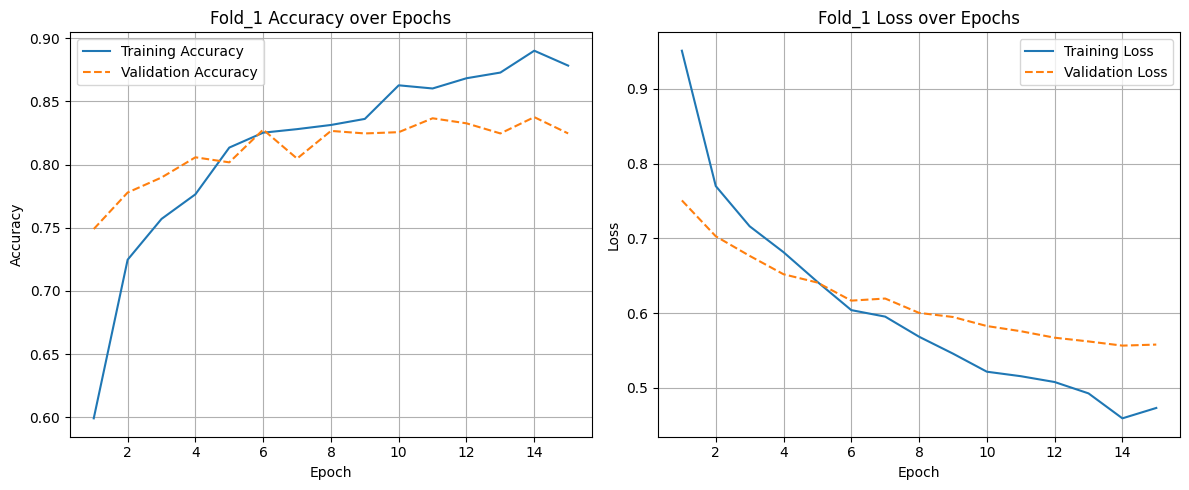

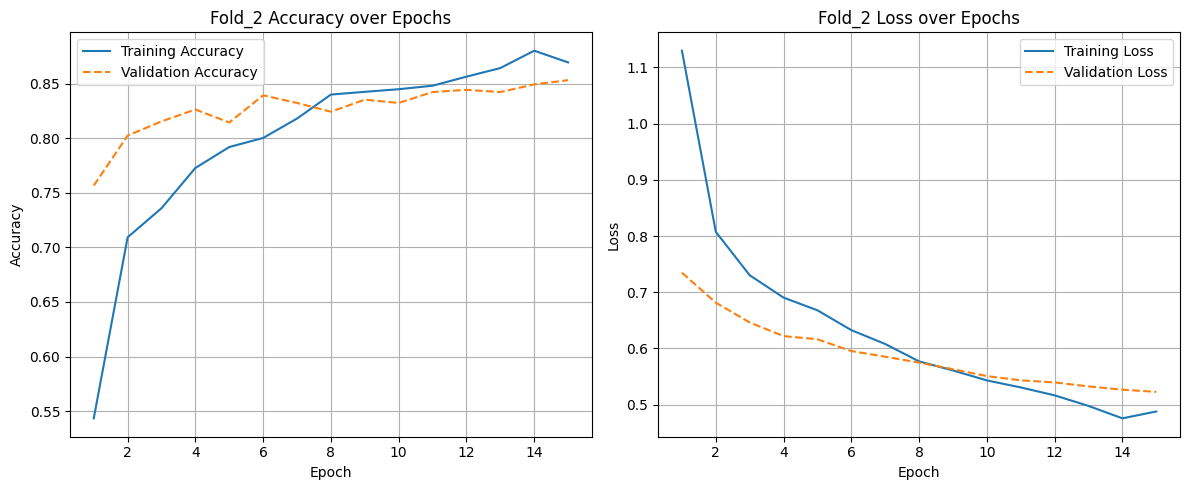

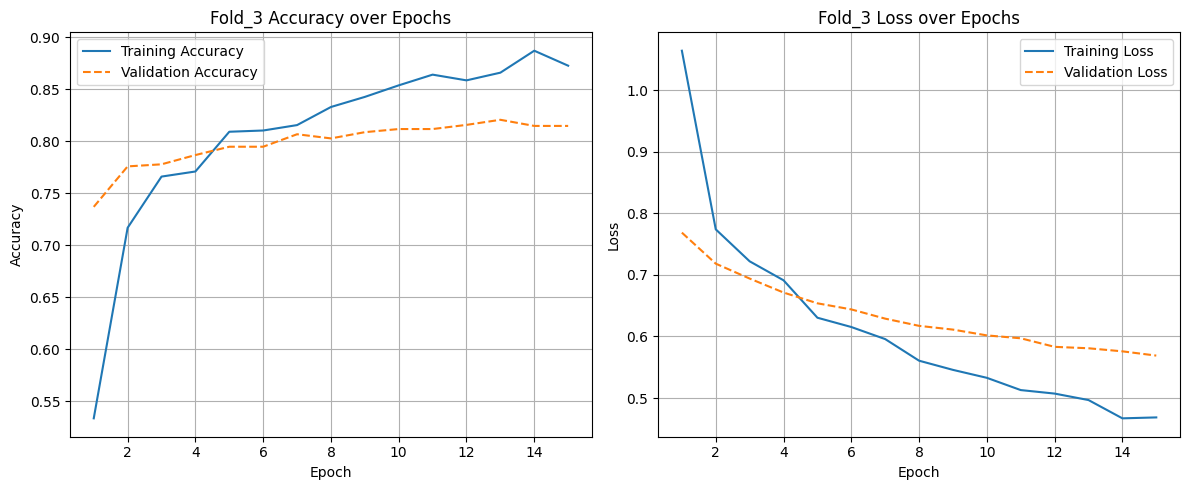

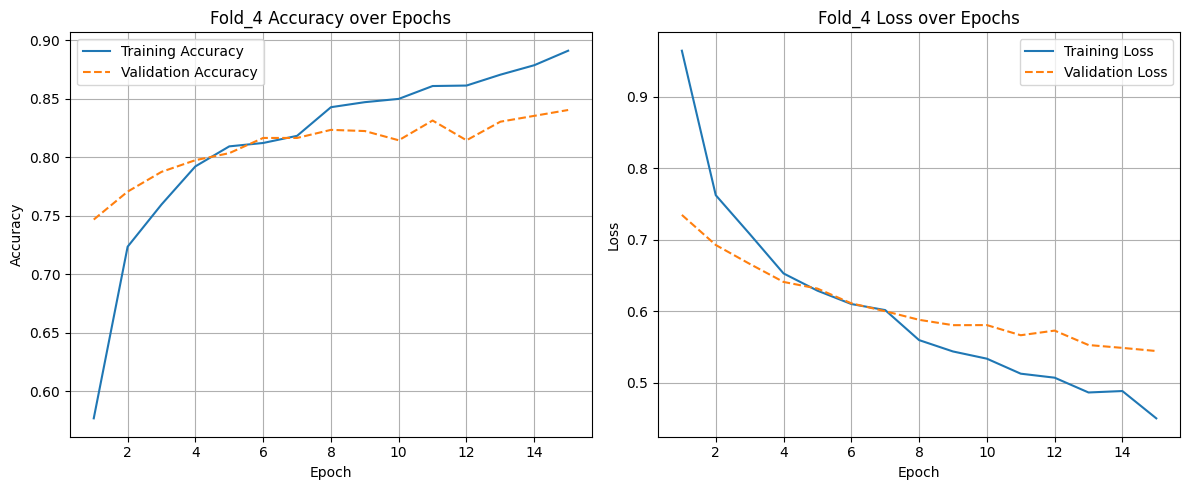

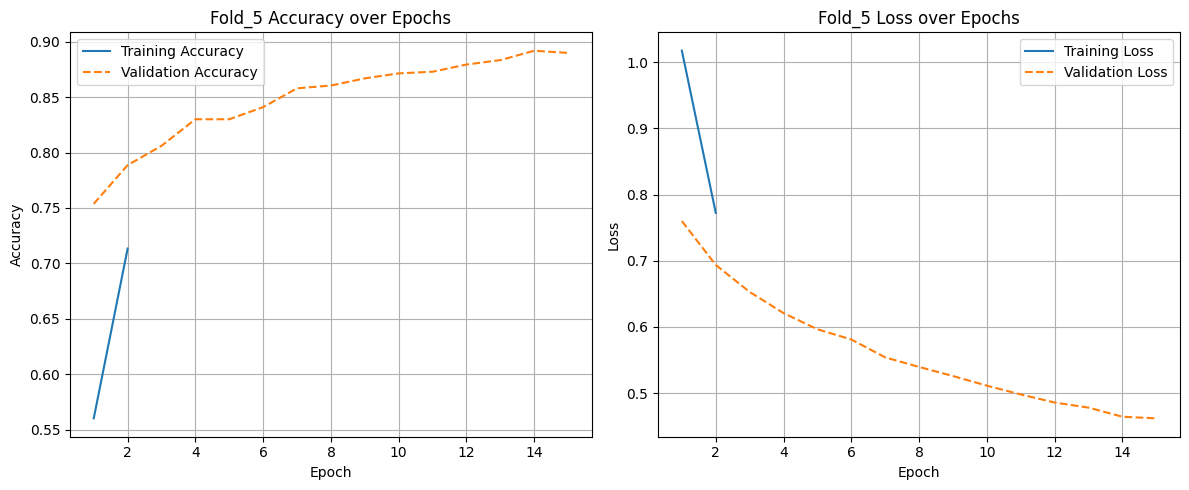

In [ ]:
print("Generating performance plots for all folds:")
plot_metrics(training_metrics)

In [ ]:
def crop_face_and_segment(img_path):
    img = cv2.imread(img_path)
    if img is None:
        return None

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    face_cascade = cv2.CascadeClassifier(
        cv2.data.haarcascades + "haarcascade_frontalface_default.xml"
    )

    faces = face_cascade.detectMultiScale(gray, 1.1, 4, minSize=(30, 30))

    if len(faces) == 0:
        return cv2.resize(img, IMG_SIZE)

    x, y, w, h = faces[0]
    face = img[y:y+h, x:x+w]

    hsv = cv2.cvtColor(face, cv2.COLOR_BGR2HSV)
    lower = np.array([0, 30, 60])
    upper = np.array([20, 150, 255])

    mask = cv2.inRange(hsv, lower, upper)
    mask = cv2.GaussianBlur(mask, (5,5), 0)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, np.ones((5,5), np.uint8))

    if mask.sum() < 10:
        output = cv2.resize(face, IMG_SIZE)
    else:
        segmented = cv2.bitwise_and(face, face, mask=mask)
        output = cv2.resize(segmented, IMG_SIZE)

    return output


In [ ]:
def find_last_conv_layer(model):
    for layer in reversed(model.layers):
        if isinstance(layer, tf.keras.layers.Conv2D):
            return layer.name
    raise ValueError("No Conv2D layer found")

last_conv_layer = find_last_conv_layer(model)
print("Last Conv Layer:", last_conv_layer)


Last Conv Layer: Conv_1


In [ ]:
def preprocess_with_segmentation(img_path):
    processed = crop_face_and_segment(img_path)
    if processed is None:
        return None

    processed = processed / 255.0
    return np.expand_dims(processed, axis=0)


In [ ]:
def compute_gradcam(model, img_tensor, last_conv_layer_name):
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_tensor)
        # For binary classification with a single output neuron, predictions[0] is the probability of class 1.
        loss = predictions[:, 0]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0,1,2))

    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(conv_outputs * pooled_grads, axis=-1)

    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap) + 1e-8

    # Return both heatmap and the prediction probability
    return heatmap, predictions[0][0]

In [ ]:
def overlay_gradcam(img_path, heatmap, alpha=0.4):
    img = crop_face_and_segment(img_path)
    img = cv2.resize(img, IMG_SIZE)

    heatmap = cv2.resize(heatmap, IMG_SIZE)
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    overlay = cv2.addWeighted(img, 1-alpha, heatmap, alpha, 0)
    return overlay


In [ ]:
img_tensor = preprocess_with_segmentation(img_path)

heatmap = compute_gradcam(
    model,
    img_tensor,
    last_conv_layer
)

gradcam_img = overlay_gradcam(img_path, heatmap)


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['input_layer_10']]
Received: inputs=Tensor(shape=(1, 128, 128, 3))
  warnings.warn(msg)


In [ ]:
def find_last_conv_layer(model):
    for layer in reversed(model.layers):
        if isinstance(layer, tf.keras.layers.Conv2D):
            return layer.name
    raise ValueError("No Conv2D layer found in the model.")


In [ ]:
def display_gradcam_from_array(img_arr, model, last_conv_name):
    input_tensor = np.expand_dims(img_arr / 255.0, 0).astype(np.float32)

    # Grad model
    grad_model = tf.keras.models.Model(
        inputs=model.inputs,
        outputs=[
            model.get_layer(last_conv_name).output,
            model.output
        ]
    )

    with tf.GradientTape() as tape:
        conv_outputs, preds = grad_model(input_tensor)
        loss = preds[:, 0]   # binary MobileNet output

    grads = tape.gradient(loss, conv_outputs)

    conv_outputs = conv_outputs[0]
    grads = grads[0]

    weights = tf.reduce_mean(grads, axis=(0,1))
    cam = tf.reduce_sum(tf.multiply(weights, conv_outputs), axis=-1)

    cam = np.maximum(cam, 0)
    cam /= np.max(cam) + 1e-8
    cam = cv2.resize(cam, IMG_SIZE)

    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    overlay = np.uint8(0.4 * heatmap + img_arr)

    prob = preds[0][0].numpy()
    label = "REAL" if prob >= 0.5 else "FAKE"

    plt.figure(figsize=(6,6))
    plt.imshow(overlay)
    plt.title(f"{label} (score={prob:.4f})")
    plt.axis('off')
    plt.show()

    return prob, label


In [ ]:
def predict_and_gradcam(img_path, model, last_conv_name=None):
    if last_conv_name is None:
        last_conv_name = find_last_conv_layer(model)

    img_arr = crop_face_and_segment(img_path)
    img_arr_rgb = cv2.cvtColor(img_arr, cv2.COLOR_BGR2RGB)

    prob, label = display_gradcam_from_array(
        img_arr_rgb,
        model,
        last_conv_name
    )

    return prob, label


In [ ]:
uploaded = files.upload()

for filename in uploaded.keys():
    img_path = filename
    break


Saving Screenshot 2025-11-15 204218.png to Screenshot 2025-11-15 204218.png


In [ ]:
best_model = tf.keras.models.load_model(
    "/content/drive/MyDrive/deepfake_models/fold_1_epoch_10.keras"
)

/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer_10']
Received: inputs=Tensor(shape=(1, 128, 128, 3))
  warnings.warn(msg)


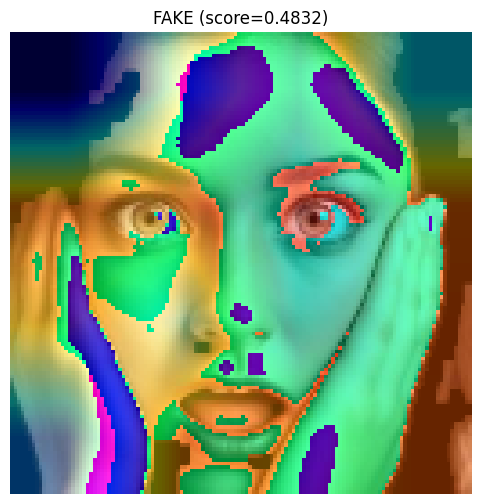

Prediction: FAKE, Probability: 0.4832


In [ ]:
last_conv = find_last_conv_layer(best_model)

prob, label = predict_and_gradcam(
    img_path,
    best_model,
    last_conv
)

print(f"Prediction: {label}, Probability: {prob:.4f}")


In [ ]:
uploaded = files.upload()

for filename in uploaded.keys():
    img_path = filename
    break


Saving Screenshot 2025-11-15 211926.png to Screenshot 2025-11-15 211926.png


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer_10']
Received: inputs=Tensor(shape=(1, 128, 128, 3))
  warnings.warn(msg)


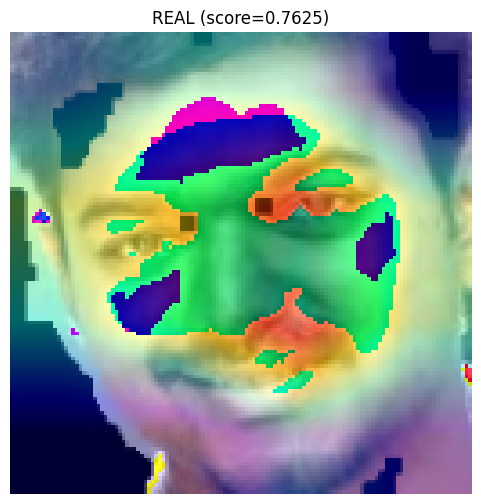

Prediction: REAL, Probability: 0.7625


In [ ]:
last_conv = find_last_conv_layer(best_model)

prob, label = predict_and_gradcam(
    img_path,
    best_model,
    last_conv
)

print(f"Prediction: {label}, Probability: {prob:.4f}")


In [ ]:

uploaded = files.upload()

for filename in uploaded.keys():
    img_path = filename
    break


Saving Screenshot 2025-12-01 163500.png to Screenshot 2025-12-01 163500.png


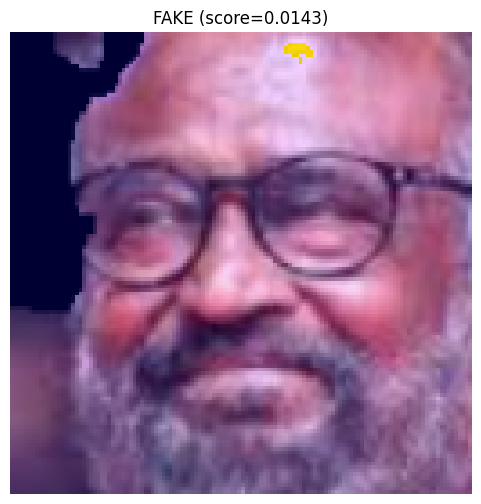

Prediction: FAKE, Probability: 0.0143


In [ ]:
last_conv = find_last_conv_layer(best_model)

prob, label = predict_and_gradcam(
    img_path,
    best_model,
    last_conv
)

print(f"Prediction: {label}, Probability: {prob:.4f}")


In [ ]:
uploaded = files.upload()

for filename in uploaded.keys():
    img_path = filename
    break


Saving Screenshot 2025-11-15 212120.png to Screenshot 2025-11-15 212120.png


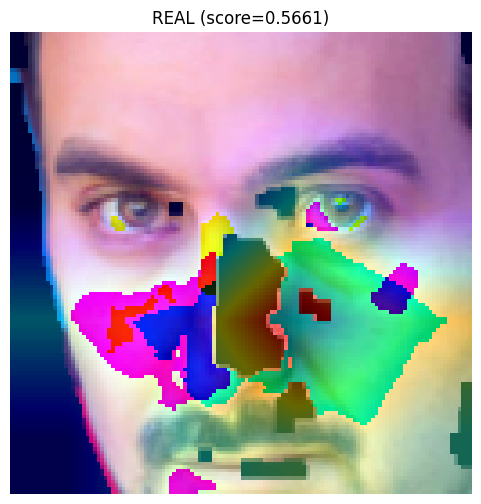

Prediction: REAL, Probability: 0.5661


In [ ]:
last_conv = find_last_conv_layer(best_model)

prob, label = predict_and_gradcam(
    img_path,
    best_model,
    last_conv
)

print(f"Prediction: {label}, Probability: {prob:.4f}")


In [ ]:
uploaded = files.upload()

for filename in uploaded.keys():
    img_path = filename
    break


Saving Screenshot 2025-11-15 211558.png to Screenshot 2025-11-15 211558.png


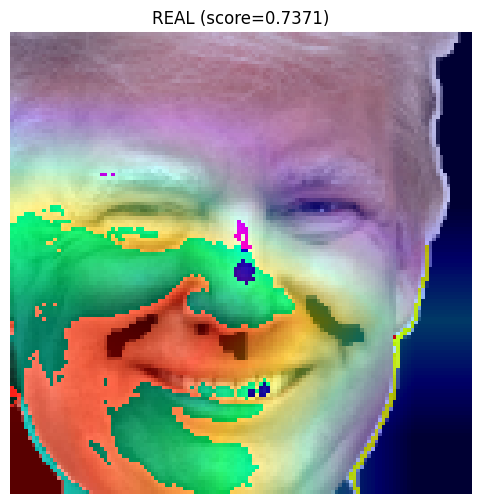

Prediction: REAL, Probability: 0.7371


In [ ]:
last_conv = find_last_conv_layer(best_model)

prob, label = predict_and_gradcam(
    img_path,
    best_model,
    last_conv
)

print(f"Prediction: {label}, Probability: {prob:.4f}")


In [ ]:
uploaded = files.upload()

for filename in uploaded.keys():
    img_path = filename
    break


Saving Screenshot 2025-11-15 205912.png to Screenshot 2025-11-15 205912.png


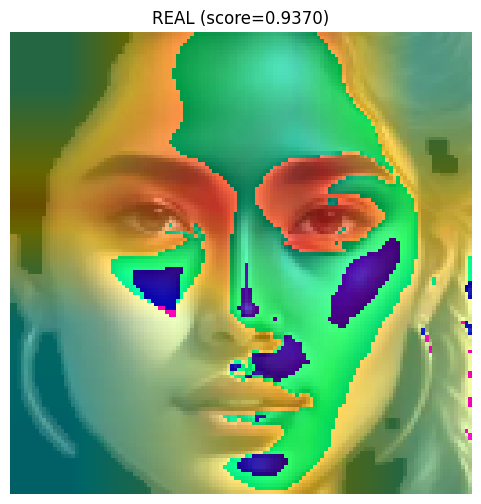

Prediction: REAL, Probability: 0.9370


In [ ]:
last_conv = find_last_conv_layer(best_model)

prob, label = predict_and_gradcam(
    img_path,
    best_model,
    last_conv
)

print(f"Prediction: {label}, Probability: {prob:.4f}")


Saving Screenshot 2025-10-13 170018.png to Screenshot 2025-10-13 170018.png


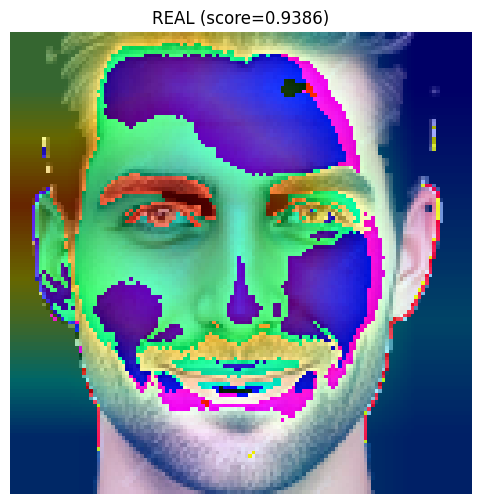

Prediction: REAL, Probability: 0.9386


In [ ]:
uploaded = files.upload()

for filename in uploaded.keys():
    img_path = filename
    break
    last_conv = find_last_conv_layer(best_model)

prob, label = predict_and_gradcam(
    img_path,
    best_model,
    last_conv
)

print(f"Prediction: {label}, Probability: {prob:.4f}")



Saving Screenshot 2025-10-13 163804.png to Screenshot 2025-10-13 163804 (1).png


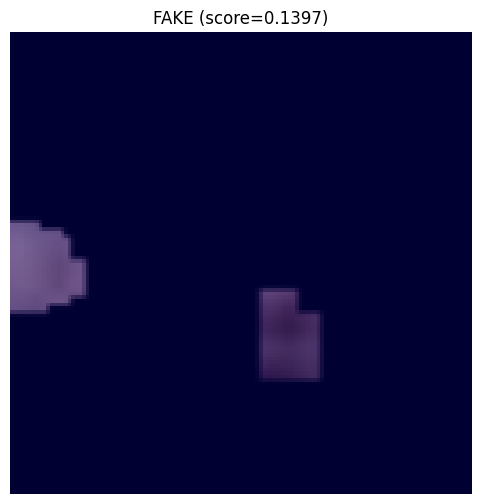

Prediction: FAKE, Probability: 0.1397


In [ ]:
uploaded = files.upload()

for filename in uploaded.keys():
    img_path = filename
    break
    last_conv = find_last_conv_layer(best_model)

prob, label = predict_and_gradcam(
    img_path,
    best_model,
    last_conv
)

print(f"Prediction: {label}, Probability: {prob:.4f}")


Saving Screenshot 2025-10-13 170233.png to Screenshot 2025-10-13 170233.png


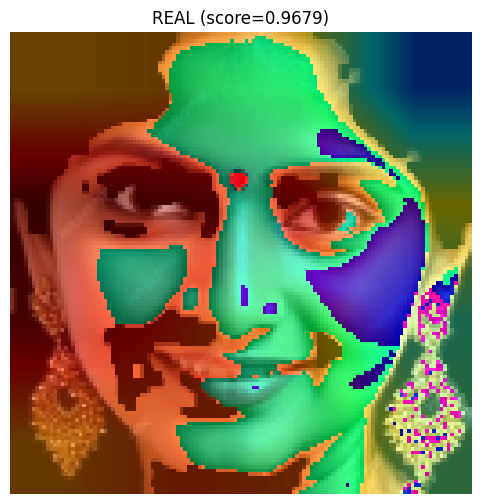

Prediction: REAL, Probability: 0.9679


In [ ]:
uploaded = files.upload()

for filename in uploaded.keys():
    img_path = filename
    break
    last_conv = find_last_conv_layer(best_model)

prob, label = predict_and_gradcam(
    img_path,
    best_model,
    last_conv
)

print(f"Prediction: {label}, Probability: {prob:.4f}")


Saving WhatsApp Image 2025-10-14 at 14.24.36_32691c17.jpg to WhatsApp Image 2025-10-14 at 14.24.36_32691c17.jpg


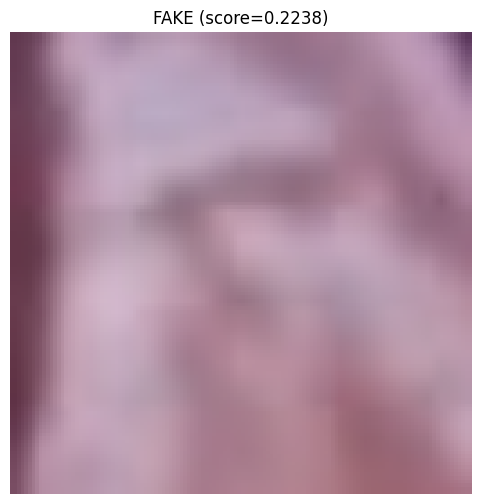

Prediction: FAKE, Probability: 0.2238


In [ ]:
uploaded = files.upload()

for filename in uploaded.keys():
    img_path = filename
    break
    last_conv = find_last_conv_layer(best_model)

prob, label = predict_and_gradcam(
    img_path,
    best_model,
    last_conv
)

print(f"Prediction: {label}, Probability: {prob:.4f}")
